## Analyze StrainGE output in Python

Now that we have run StrainGST and StrainGR (including the compare step), how do we analyze the outputs? This page uses Python and its commonly used data science stack (NumPy, SciPy, Pandas and matplotlib+seaborn) to parse the data, plot the relative abundances of strains over time, and generate an ACNI/gap similarity plot.

### Download data

We download an archive containing StrainGE outputs part of the vignette described in the paper on the persistence of an *E. coli* strain in the gut of a woman with recurrent urinary tract infections. The extracted data is organized in a `straingst` and `straingr` folder.

In [3]:
!curl --output umb_data.tar.gz https://raw.githubusercontent.com/broadinstitute/strainge-paper/master/umb/umb_data.tar.gz
!tar -xzvf umb_data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12196  100 12196    0     0  21624      0 --:--:-- --:--:-- --:--:-- 21585
x straingst/UMB11_01.tsv
x straingst/UMB11_02.tsv
x straingst/UMB11_03.1.tsv
x straingst/UMB11_03.tsv
x straingst/UMB11_04.1.tsv
x straingst/UMB11_04.tsv
x straingst/UMB11_05.tsv
x straingst/UMB11_06.tsv
x straingst/UMB11_07.tsv
x straingst/UMB11_08.tsv
x straingst/UMB11_11.tsv
x straingst/UMB11_12.tsv
x straingr/UMB11_01.tsv
x straingr/UMB11_02.tsv
x straingr/UMB11_03.1.tsv
x straingr/UMB11_03.tsv
x straingr/UMB11_04.1.tsv
x straingr/UMB11_04.tsv
x straingr/UMB11_05.tsv
x straingr/UMB11_06.tsv
x straingr/UMB11_07.tsv
x straingr/UMB11_08.tsv
x straingr/UMB11_11.tsv
x straingr/UMB11_12.tsv
x straingr/compare.summary.chrom.txt


### Import required modules


In [1]:
from pathlib import Path

import numpy
import pandas
import matplotlib.pyplot as plt


### StrainGST

#### Read StrainGST outputs and combine it in a DataFrame

The TSV files written by StrainGST contain both sample statistics (the first two lines), and statistics for each identified strain (see [StrainGST](straingst.md) page). In this tutorial, we are mainly interested in the identified strains. In the code below, when calling `pandas.read_csv`, we give the argument `skiprows=2` to skip the sample statistics.


In [4]:
STRAINGST_DIR = Path("straingst/")

df_list = []
sample_names = []
for f in STRAINGST_DIR.glob("*.tsv"):
    sample_name = f.stem
    df = pandas.read_csv(f, sep='\t', comment='#', skiprows=2, index_col=1)

    df_list.append(df)
    sample_names.append(sample_name)


# Combine all StrainGST results from each sample into a single DataFrame.
straingst_df = pandas.concat(df_list, keys=sample_names, names=["sample"])

sample_names = list(sorted(sample_names, key=lambda e: float(e.replace("UMB11_", ""))))
straingst_df

i gkmers ikmers  \
sample     strain                                                            
UMB11_11   Esch_coli_1190                                  0  48261  48248   
UMB11_05   Esch_coli_1190                                  0  48261  48248   
UMB11_06   Esch_coli_H3                                    0  45610  45560   
           Esch_coli_1190                                  1  48261  21600   
UMB11_12   Esch_coli_1190                                  0  48261  48235   
           Esch_coli_26561                                 1  46249  19738   
UMB11_07   Esch_coli_1190                                  0  48261  48237   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8  1  47727  21265   
UMB11_03   Esch_coli_1190                                  0  48261  48249   
UMB11_02   Esch_coli_NGF1                                  0  49631  49623   
UMB11_01   Esch_coli_NGF1                                  0  49631  49622   
UMB11_03.1 Esch_coli_1190                                  0  48261  48254   
UMB11_04.1 Esch_coli_1190                                  0  48261  48250   
UMB11_08   Esch_coli_1190                                  0  48261  48248   

                                                          skmers    cov  \
sample     strain                                                         
UMB11_11   Esch_coli_1190                                  49462  0.920   
UMB11_05   Esch_coli_1190                                  40411  0.775   
UMB11_06   Esch_coli_H3                                    74449  0.960   
           Esch_coli_1190                                  30714  0.794   
UMB11_12   Esch_coli_1190                                  66509  0.941   
           Esch_coli_26561                                 21112  0.853   
UMB11_07   Esch_coli_1190                                  58276  0.854   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8  17074  0.441   
UMB11_03   Esch_coli_1190                                  37144  0.711   
UMB11_02   Esch_coli_NGF1                                   5358  0.103   
UMB11_01   Esch_coli_NGF1                                  50090  0.985   
UMB11_03.1 Esch_coli_1190                                  31201  0.595   
UMB11_04.1 Esch_coli_1190                                  19042  0.362   
UMB11_08   Esch_coli_1190                                  31599  0.592   

                                                              kcov     gcov  \
sample     strain                                                             
UMB11_11   Esch_coli_1190                                    6.107    5.545   
UMB11_05   Esch_coli_1190                                    2.741    2.097   
UMB11_06   Esch_coli_H3                                    114.343  109.038   
           Esch_coli_1190                                    7.102    5.565   
UMB11_12   Esch_coli_1190                                    9.061    8.431   
           Esch_coli_26561                                   4.773    3.983   
UMB11_07   Esch_coli_1190                                    4.557    3.846   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8    2.588    1.077   
UMB11_03   Esch_coli_1190                                    2.814    1.975   
UMB11_02   Esch_coli_NGF1                                    1.546    0.158   
UMB11_01   Esch_coli_NGF1                                    7.009    6.831   
UMB11_03.1 Esch_coli_1190                                    2.152    1.264   
UMB11_04.1 Esch_coli_1190                                    1.870    0.668   
UMB11_08   Esch_coli_1190                                    2.243    1.309   

                                                            acct   even  \
sample     strain                                                         
UMB11_11   Esch_coli_1190                                  0.920  0.923   
UMB11_05   Esch_coli_1190                                  0.923  0.884   
UMB11_06   Esch_coli_H3                     

#### Plot relative abundances


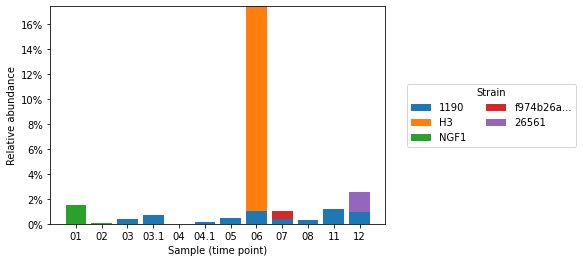

In [6]:
plt.figure(figsize=(6, 4))

strain_order = ['Esch_coli_1190', 'Esch_coli_H3', 'Esch_coli_NGF1', 'Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8', "Esch_coli_26561"]
strain_labels = ['1190', 'H3', 'NGF1', 'f974b26a...', "26561"]
xlabels = [s.replace("UMB11_", "") for s in sample_names]

x = numpy.arange(len(sample_names))
bottom = numpy.zeros((len(sample_names),))
for ref, label in zip(strain_order, strain_labels):
    # Create an array with all relative abundances for the current reference in each sample. If not available, set to zero.
    rel_abun = numpy.array([
        straingst_df.loc[(sample, ref), 'rapct'] if (sample, ref) in straingst_df.index else 0.0
        for sample in sample_names
    ])

    plt.bar(x, rel_abun, bottom=bottom, tick_label=xlabels, label=label, width=0.8)
    bottom += rel_abun

plt.xlabel("Sample (time point)")
plt.ylabel("Relative abundance")
plt.gca().yaxis.set_major_formatter("{x:g}%")
plt.legend(title="Strain", loc="center left", bbox_to_anchor=(1.05, 0.5), ncol=2)

plt.show()

### StrainGR

#### Load data in a DataFrame

To load StrainGR outputs, we use a similar approach as descried above. In this case, the StrainGR TSV files can be directly loaded with pandas without `skiprows`.

One thing to note, StrainGR outputs metrics for every contig in the concatenated reference used for alignment. The output file thus contains metrics for **contigs from strains that were not predicted to be present by StrainGST**. We use the presence/absence predictions of StrainGST as our "truth" and remove the contigs from strains that weren't present.

We apply a few other filters, including removing plasmid contigs, and contigs with less coverage than 0.5x.

In [12]:
STRAINGR_DIR = Path("straingr/")

df_list = []
sample_names = []
for f in STRAINGR_DIR.glob("*.tsv"):
    df = pandas.read_csv(f, sep='\t', index_col=0)
    df = df.drop(index='TOTAL')  # Remove TOTAL statistics

    df_list.append(df)
    sample_names.append(f.stem)

straingr_df = pandas.concat(df_list, keys=sample_names, names=["sample"])
straingr_df['straingst_present'] = straingr_df.index.map(lambda ix: ix in straingst_df.index)
straingr_df['is_plasmid'] = straingr_df['length'] < 4e6
straingr_df['enough_cov'] = straingr_df['coverage'] > 0.5
straingr_df = straingr_df[straingr_df['straingst_present'] & ~straingr_df['is_plasmid'] & straingr_df['enough_cov']].copy()
straingr_df.sort_index()

name  \
sample     ref                                                             
UMB11_01   Esch_coli_NGF1                                  NZ_CP016007.1   
UMB11_03   Esch_coli_1190                                  NZ_CP023386.1   
UMB11_03.1 Esch_coli_1190                                  NZ_CP023386.1   
UMB11_06   Esch_coli_1190                                  NZ_CP023386.1   
           Esch_coli_H3                                    NZ_CP010167.1   
UMB11_07   Esch_coli_1190                                  NZ_CP023386.1   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8  NZ_LR536430.1   
UMB11_08   Esch_coli_1190                                  NZ_CP023386.1   
UMB11_11   Esch_coli_1190                                  NZ_CP023386.1   

                                                            length  coverage  \
sample     ref                                                                 
UMB11_01   Esch_coli_NGF1                                  5026105     3.549   
UMB11_03   Esch_coli_1190                                  4900891     0.822   
UMB11_03.1 Esch_coli_1190                                  4900891     0.596   
UMB11_06   Esch_coli_1190                                  4900891     1.963   
           Esch_coli_H3                                    4630919    47.519   
UMB11_07   Esch_coli_1190                                  4900891     1.591   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8  4975029     0.700   
UMB11_08   Esch_coli_1190                                  4900891     0.580   
UMB11_11   Esch_coli_1190                                  4900891     2.492   

                                                            uReads  abundance  \
sample     ref                                                                  
UMB11_01   Esch_coli_NGF1                                    85824      0.823   
UMB11_03   Esch_coli_1190                                    35131      0.143   
UMB11_03.1 Esch_coli_1190                                    24708      0.278   
UMB11_06   Esch_coli_1190                                    69465      0.264   
           Esch_coli_H3                                    1331869      7.902   
UMB11_07   Esch_coli_1190                                    59112      0.347   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8    14686      0.132   
UMB11_08   Esch_coli_1190                                    24145      0.118   
UMB11_11   Esch_coli_1190                                   106232      0.449   

                                                           median  callable  \
sample     ref                                                                
UMB11_01   Esch_coli_NGF1                                       3   2506998   
UMB11_03   Esch_coli_1190                                       1    859998   
UMB11_03.1 Esch_coli_1190                                       0    547015   
UMB11_06   Esch_coli_1190                                       2   1515111   
           Esch_coli_H3                                        48   3863102   
UMB11_07   Esch_coli_1190                                       1   1894740   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8       0    378975   
UMB11_08   Esch_coli_1190                                       0    505713   
UMB11_11   Esch_coli_1190                                       2   2819899   

                                                           callablePct  \
sample     ref                                                           
UMB11_01   Esch_coli_NGF1                                       49.880   
UMB11_03   Esch_coli_1190                                       17.548   
UMB11_03.1 Esch_coli_1190                                       11.162   
UMB11_06   Esch_coli_1190                                       30.915   
           Esch_coli_H3                                         83.420   
UMB11_07   Esch_coli_1190                                       38.661